# **Installing the dependencies**

In [ ]:
# Uncomment the line below and run the cell to install the required packages
# %pip install numpy imageio matplotlib pandas scikit-learn

# **Importing the necessary libraries for this notebook**

In [1]:
import numpy as np
import imageio.v2 as imageio
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from sklearn.multiclass import OneVsRestClassifier as OVRC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
%matplotlib inline

# **Loading and visualizing the datasets**

(540, 2500) (540,)


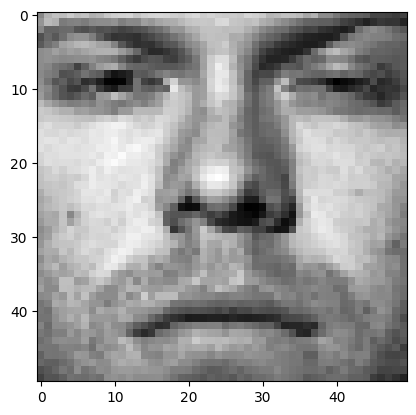

In [2]:
train_labels, train_data = [], []

# Read the image file names and labels from the text file and load the images
for line in open('./faces/train.txt'):
    im = imageio.imread(line.strip().split()[0])
    train_data.append(im.reshape(2500,))
    train_labels.append(line.strip().split()[1])

# Convert to numpy arrays.
X = np.array(train_data, dtype=float)
train_labels = np.array(train_labels, dtype=int)

# Displaying the grayscale image.
print(X.shape, train_labels.shape)
plt.imshow(X[10,:].reshape(50,50), cmap=cm.Greys_r)
plt.show()

(100, 2500) (100,)


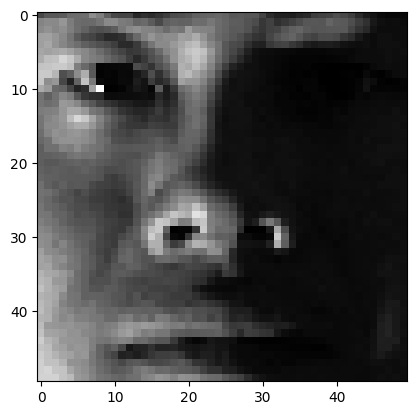

In [3]:
test_labels, test_data = [], []

# Read the image file names and labels from the text file and load the images.
for line in open('./faces/test.txt'):
    im = imageio.imread(line.strip().split()[0])
    test_data.append(im.reshape(2500,))
    test_labels.append(line.strip().split()[1])

# Convert to numpy arrays.
X_test = np.array(test_data, dtype=float)
test_labels = np.array(test_labels, dtype=int)

# Displaying the grayscale image.
print(X_test.shape, test_labels.shape)
plt.imshow(X_test[10,:].reshape(50,50), cmap=cm.Greys_r)
plt.show()

**Calculating the average face μ of the whole training set**

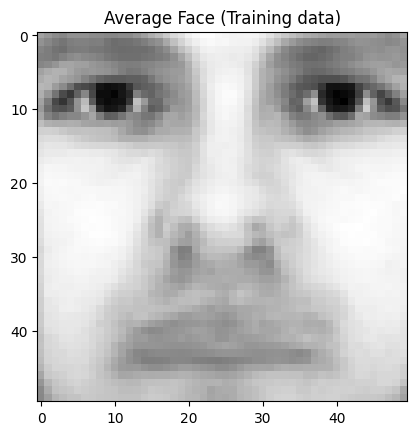

In [4]:
def compute_avg_faces(data_set):
    """
    Computes the average face mean from the whole dataset.
    """
    # Convert each image into a vector and stack them into a matrix.
    image_shape = data_set[0].shape
    image_vectors = np.array([image.flatten() for image in data_set])
    
    # Compute the average face vector.
    avg_face_vector = np.mean(image_vectors, axis=0)
    
    # Reshape the average face vector back to the original image shape.
    avg_face = avg_face_vector.reshape(image_shape)
    
    return avg_face, image_vectors

avg_face, image_vect = compute_avg_faces(X)

# Displaying the grayscale image.
plt.imshow(avg_face.reshape(50, 50), cmap=cm.Greys_r)
plt.title("Average Face (Training data)")
plt.show()

**Subtracting the average face μ from every row**

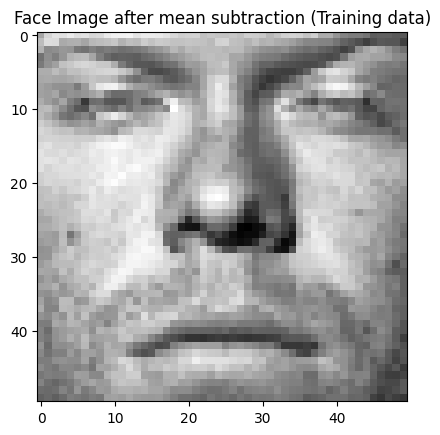

In [5]:
def subtract_avg_face(image_vectors, avg_face_vector):
    """
    Subtracts the average face mean from every row.
    """
    # Subtract the average face vector from each image.
    centered_vector = image_vectors - avg_face_vector
    return centered_vector

centered_train_vec = subtract_avg_face(image_vect, avg_face.flatten())

# Pick a face image after mean subtraction from the training data.
train_image_vect = centered_train_vec[10]
train_img = train_image_vect.reshape(X[10].shape)

# Displaying the grayscale image.
plt.imshow(train_img.reshape(50, 50), cmap=cm.Greys_r)
plt.title("Face Image after mean subtraction (Training data)")
plt.show()

**Repeating the process for the test set**

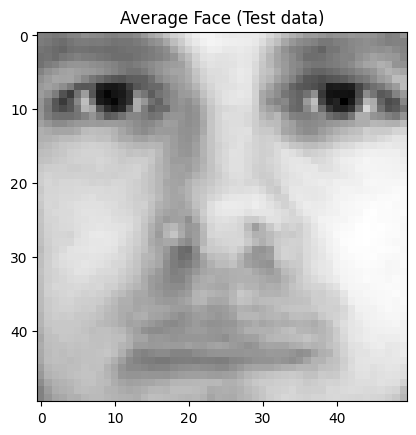

In [6]:
# Computing the average face mean of the test data set.
avg_face_test, test_image_vect = compute_avg_faces(X_test)

# Displaying the grayscale image.
plt.imshow(avg_face_test.reshape(50, 50), cmap=cm.Greys_r)
plt.title("Average Face (Test data)")
plt.show()

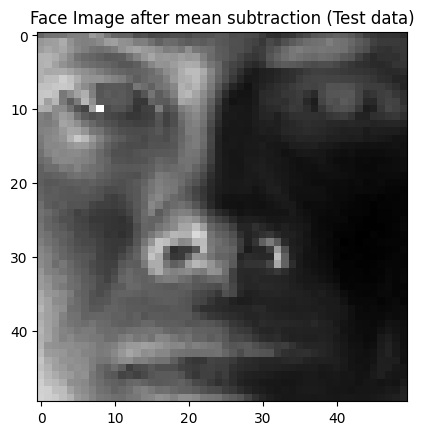

In [7]:
# Subtracting the average face mean from every row.
centered_test_vec = subtract_avg_face(test_image_vect, avg_face_test.flatten())

# Picking a face image after mean subtraction from the test data.
test_image_vect = centered_test_vec[10]
test_img = test_image_vect.reshape(test_data[10].shape)

# Displaying the grayscale image.
plt.imshow(test_img.reshape(50, 50), cmap=cm.Greys_r)
plt.title("Face Image after mean subtraction (Test data)")
plt.show()

**Perform Eigendecomposition**

In [8]:
# Compute the covariance matrix.
cov_matrix = np.dot(X.T, X)

# Perform eigendecompoition.
eigen_vals, eigen_vects = np.linalg.eigh(cov_matrix)

# Sort eigenvectors by eigenvalues in descendin order.
sorted_indices = np.argsort(eigen_vals)[::-1]
sorted_eigenvects = eigen_vects[:, sorted_indices]

**Display the first 10 Eigenfaces**

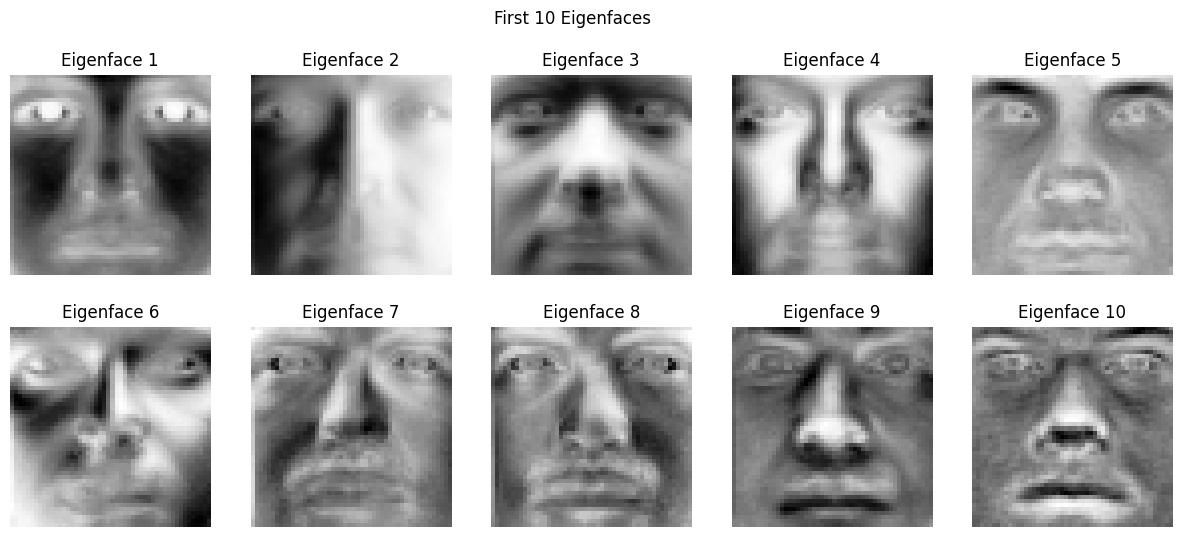

In [9]:
# Display the first 10 eigenfaces.
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    eigenface = sorted_eigenvects[:, i].reshape(50, 50)
    ax.imshow(eigenface, cmap=cm.Greys_r)
    ax.set_title(f"Eigenface {i+1}")
    ax.axis('off')
    
plt.suptitle("First 10 Eigenfaces")
plt.show()

**Generating the r-dimensional feature matrix**

In [10]:
def generate_feature_matrix(X, X_test, eigenvectors, r):
    """
    Generates r-dimensional feature matrices for training and test images.
    """
    
    # Select the top r eigenfaces
    top_r_ef = eigenvectors[:, :r]
    
    # Compute the feature matrices
    F = np.dot(X, top_r_ef)
    F_test = np.dot(X_test, top_r_ef)
    
    return F, F_test

r = 10 # Number of eigenfaces to use
F, F_test = generate_feature_matrix(X, X_test, sorted_eigenvects, r)

In [11]:
# Convert the feature matrices to DataFrames
df_F = pd.DataFrame(F, columns=[f"feature {i+1}" for i in range(F.shape[1])])
df_F_test = pd.DataFrame(F_test, columns=[f"feature {i+1}" for i in range(F_test.shape[1])])

# Display the first 5 rows of each feature matrix as a table
print("Training Feature Matrix (first 5 rows):")
print(df_F.head(5))

print("\nTest Feature Matrix (first 5 rows):")
print(df_F_test.head(5))

Training Feature Matrix (first 5 rows):
     feature 1   feature 2   feature 3   feature 4  feature 5  feature 6  \
0  -474.967376  217.973968  170.961814 -170.905220  37.164439  51.122052   
1 -5655.633799  901.983289 -794.461758  123.932887 -35.611795 -94.690923   
2 -6041.241728   -1.298542  175.008144  737.873210 -59.479275 -32.522456   
3 -6284.009261 -301.530178 -192.631304  554.310602 -53.015177  11.633871   
4 -5892.869828  -27.421869 -480.470909  341.299097 -57.241109  -5.016253   

    feature 7   feature 8   feature 9  feature 10  
0 -120.391433  201.061492  -55.480199   74.720211  
1  249.813366  222.513172  179.620201  429.449699  
2  322.238699  -71.876845 -534.741102  406.734645  
3  358.577007   18.781839 -366.204777  403.381827  
4  240.912366   62.960630 -113.743050  412.614500  

Test Feature Matrix (first 5 rows):
     feature 1    feature 2    feature 3    feature 4   feature 5   feature 6  \
0 -5612.176712    72.684260  1125.144703  1058.109875  -17.419477  -34.63

# **Training the Logistic Regression model and visualizing its accuracy**

In [12]:
# Train and evaluate the Logistic Regression model
r_values = range(1, 201)
accuracies = []

for r in r_values:
    F, F_test = generate_feature_matrix(X, X_test, sorted_eigenvects, r)
    model = OVRC(LogisticRegression(max_iter=5700))
    model.fit(F, train_labels)
    predictions = model.predict(F_test)
    accuracy = accuracy_score(test_labels, predictions)
    accuracies.append(accuracy)

# Final accuracy score of the model.
print(f"Final accuracy score: {accuracies[-1]:.3f}")

Final accuracy score: 0.910


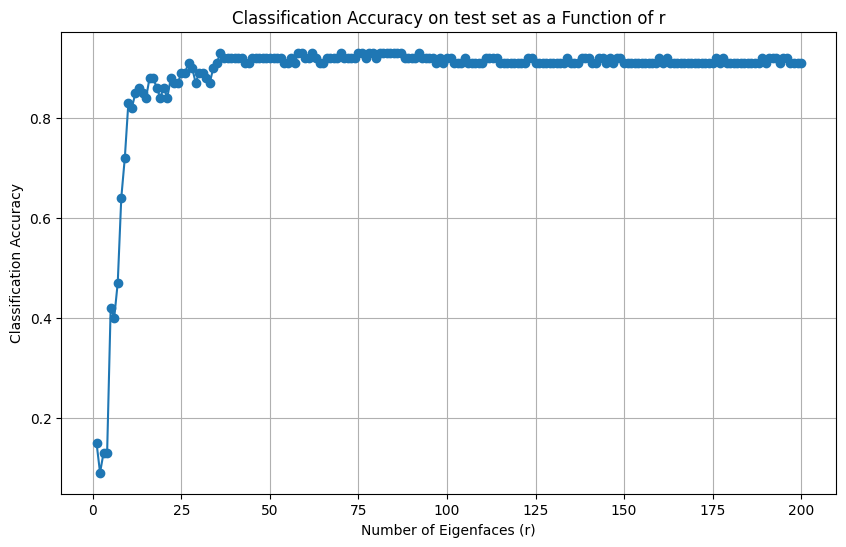

In [13]:
# Plotting the Accuracies 
plt.figure(figsize=(10, 6))
plt.plot(r_values, accuracies, marker='o')
plt.xlabel("Number of Eigenfaces (r)")
plt.ylabel("Classification Accuracy")
plt.title("Classification Accuracy on test set as a Function of r")
plt.grid(True)
plt.show()